<h2 style="background-color:#d62728;color:white;padding:10px;border-radius:8px"> Code for evaluating SSL techniques (SimCLR, Barlow twins..) efficiency and studying the latent representation</h2>

<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 1. Library import</h3>

In [84]:
import torch
print(torch.__version__)


2.7.1+cu126


In [85]:
import os
from copy import deepcopy
import sys
import zipfile

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

## Torchvision
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.datasets import STL10, PCAM
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision.models as models

#PIL
from PIL import Image
from PIL import ImageFilter

## MedMNIST
try:
  import medmnist
  from medmnist import INFO, Evaluator
except:
  !pip install medmnist
  import medmnist
  from medmnist import INFO, Evaluator

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## SKlearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

NUM_WORKERS = 16
NUM_WORKERS = os.cpu_count()//2
print("Number of workers:", NUM_WORKERS)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)

try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
  import gdown
except:
  IN_COLAB = False

Number of workers: 40


In [86]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = torch.device("cuda:0") # we use one GPU, the first one
    print ("CUDA device found.")
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.7.1+cu126
CUDA device found.


<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 2. Data Augmentation and Data Import</h3>

<div style="border-left: 6px solid #2ca02c; padding: 10px; background-color: #f0fdf4;">
<b> Here we use exactly the same data augmentation process as in <a href="https://arxiv.org/pdf/2002.05709" target="_blank">SimCLR paper</a>. We just decrease color jitter values in order to adapt to PathMNIST dataset.
</div>

In [87]:
class ContrastiveTransformations:
    def __init__(self, img_size, s=1):
      # transformations applied in SimCLR article
        color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.4*s, 0.2*s) 
        rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
        rnd_gray = transforms.RandomGrayscale(p=0.2)
        gaussian_blur = transforms.GaussianBlur(img_size//9, sigma=(0.1, 2.0)) #Change kernel size to make the kernel odd
        rnd_gauss = transforms.RandomApply([gaussian_blur], p=0.3)
        
        self.data_transform = transforms.Compose([
                transforms.RandomResizedCrop(size=img_size,scale=(0.3,1.0),ratio=(3/4,4/3)),
                transforms.RandomHorizontalFlip(p=0.5),
                rnd_color_jitter,
                rnd_gray,
                rnd_gauss,
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # values from ImageNet, so that we can use algorithms pre-trained on ImageNet
          ])

    def __call__(self, x):
      # it outputs a tuple, namely 2 views (augmentations) fo the same image
      return  self.data_transform(x),self.data_transform(x)

In [88]:
# simple transformation to use networks pre-trained on MedMINIST
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [89]:
if IN_COLAB:
  data_directory="/content/drive/MyDrive/2A/Fillieres/IMA/4IM06/Project/TP"
else:
  data_directory="./"
print(f"data directory: {data_directory}")

data directory: ./


Load the data : data_flag indicating which of the 12 dataset we want and size = 64 indicating that we want 64 x 64 images.

In [ ]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
label_names = info['label']
n_classes = len(label_names)

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(root=data_directory+"data", split='train', transform=img_transforms, download=True, size=64)
val_dataset = DataClass(root=data_directory+"data", split='val', transform=img_transforms, download=True, size=64)
test_dataset = DataClass(root=data_directory+"data", split='test', transform=img_transforms, download=True, size=64)

# Contrastive Learning dataset
unlabeled_train_dataset_cl = DataClass(root=data_directory+"data", split='train', transform=ContrastiveTransformations(img_size=64), download=False, size=64)
unlabeled_val_dataset_cl = DataClass(root=data_directory+"data", split='val', transform=ContrastiveTransformations(img_size=64), download=False, size=64)
labels = unlabeled_train_dataset_cl.labels

#train_dataset_2viewsCon = DataClass(root=data_directory+"data", split="train", transform=ContrastiveTransformations(img_size=64), download=False, size=64)

In [90]:
def load_data(img_transforms, contrastive_transforms,data_directory="./",reduction=5000,data_flag='pathmnist'):
    #data_flag = 'pathmnist'
    #data_flag = 'bloodmnist'
    #data_flag = 'dermamnist'
    download = True
    
    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    label_names = info['label']
    n_classes = len(label_names)
    
    DataClass = getattr(medmnist, info['python_class'])
    
    # load the data
    train_dataset = DataClass(root=data_directory+"data", split='train', transform=img_transforms, download=True, size=64)
    val_dataset = DataClass(root=data_directory+"data", split='val', transform=img_transforms, download=True, size=64)
    test_dataset = DataClass(root=data_directory+"data", split='test', transform=img_transforms, download=True, size=64)
    
    # Contrastive Learning dataset
    unlabeled_train_dataset_cl = DataClass(root=data_directory+"data", split='train',transform=contrastive_transforms, download=False, size=64)
    unlabeled_val_dataset_cl = DataClass(root=data_directory+"data", split='val', transform=contrastive_transforms, download=False, size=64)
    
    if reduction:
        sizeUnlabelled=reduction
    
        unlabeled_train_dataset_cl,rest = random_split(unlabeled_train_dataset_cl, [sizeUnlabelled, len(unlabeled_train_dataset_cl)-sizeUnlabelled])

    print("Data loaded")    
    print(f"Number of train images: {len(unlabeled_train_dataset_cl)}")
    print(f"Number of validation images: {len(val_dataset)}")
    print(f"Number of test images: {len(test_dataset)}")

    return train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl

In [46]:
print(train_dataset)
print("===================")
print(train_dataset.info['label']['0'])
print("===================")
print(test_dataset)
print("===================")
print(unlabeled_train_dataset_cl[0][0][0].size())
print("===================")
print(labels.shape)

Dataset BloodMNIST of size 64 (bloodmnist_64)
    Number of datapoints: 11959
    Root location: ./data
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0


In [50]:
sizeUnlabelled=5000

unlabeled_train_dataset_cl_red,rest = random_split(unlabeled_train_dataset_cl, [sizeUnlabelled, len(unlabeled_train_dataset_cl)-sizeUnlabelled])
print(len(unlabeled_train_dataset_cl_red))

5000


In [10]:
print(label_names)

{'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


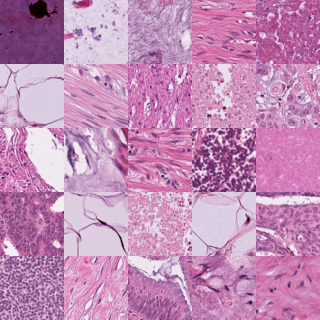

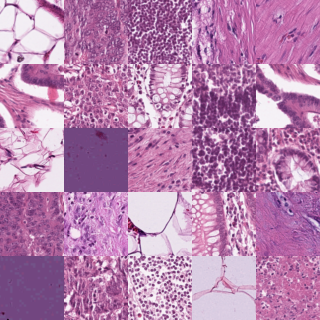

In [11]:
display(train_dataset.montage(length=5))
print("========")
display(test_dataset.montage(length=5))

In [5]:
def imshowMedMNIST2views(datasetOrig,datasetTransform,rows=5,figsize=(8, 15)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, 3*(rows-1)+2,3):
      imgOrig = datasetOrig[i][0]
      img1=datasetTransform[i][0][0]
      img2=datasetTransform[i][0][1]

      #REMOVE NORMALIZATION
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
      # Clip values to range [0,1] -> possible rounding errors during normalization
      imgOrig = np.clip(unnormalize(imgOrig).numpy(),0,1)
      img1 = np.clip(unnormalize(img1).numpy(),0,1)
      img2 = np.clip(unnormalize(img2).numpy(),0,1)

      label = str(datasetOrig[i][1][0])
      fig.add_subplot(rows, 3, i)
      plt.title(label_names[label]+ ' , original')
      plt.imshow(np.transpose(imgOrig, (1, 2, 0)))
      plt.axis("off")
      fig.add_subplot(rows, 3, i+1)
      plt.title(label_names[label] + ' , 1st view')
      plt.imshow(np.transpose(img1, (1, 2, 0)))
      plt.axis("off")
      fig.add_subplot(rows, 3, i+2)
      plt.title(label_names[label] + ' , 2nd view')
      plt.imshow(np.transpose(img2, (1, 2, 0)))
      plt.axis("off")
    plt.show()

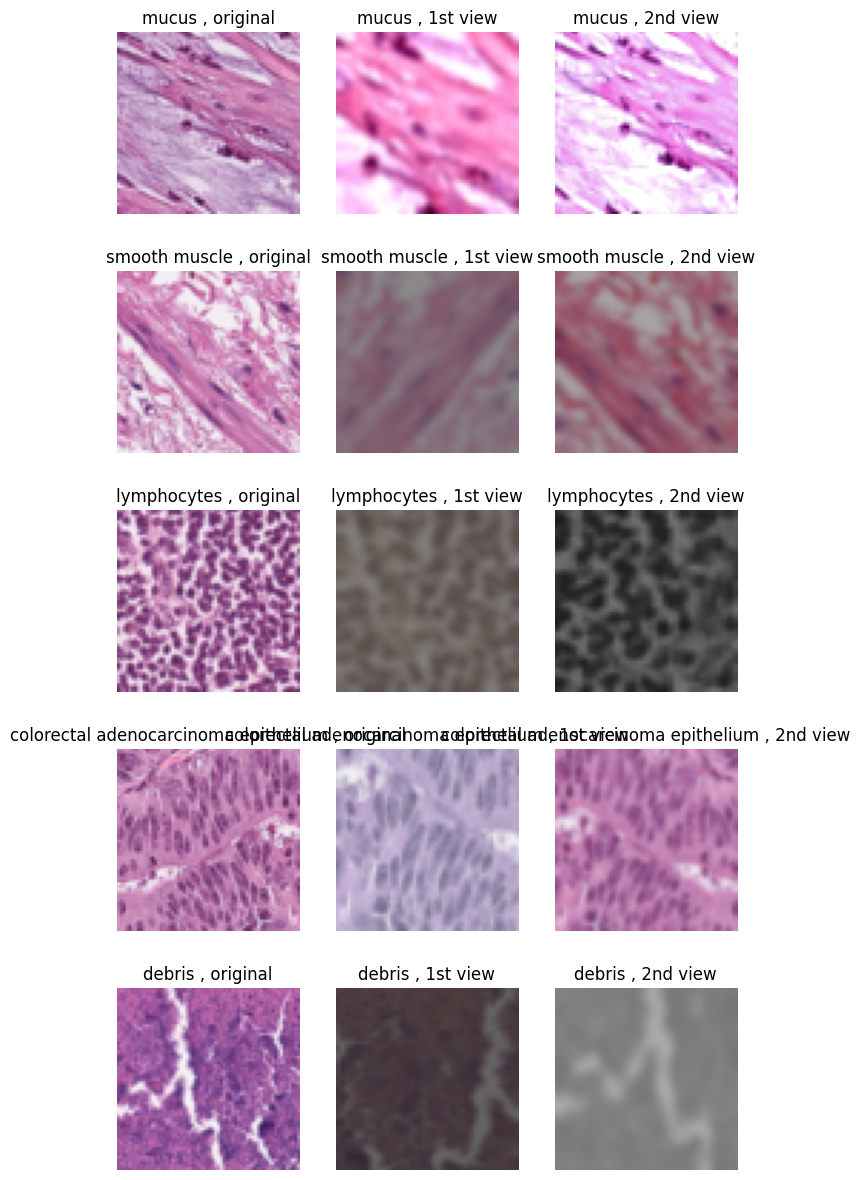

In [13]:
imshowMedMNIST2views(train_dataset,unlabeled_train_dataset_cl)

<h2 style="background-color:gray;color:white;padding:20px;border-radius:8px">First SSL technique: SimCLR</h2>

<div style="border-left: 6px solid #2ca02c; padding: 10px; background-color: #f0fdf4;">
<b> The code used here is inspired from the SimCLR practical work of the <a href="https://pietrogori.github.io/teaching/RepLearnMVA" target="_blank">Representation Learning</a> course taught by Pietro Gori and Loic Le Flogoc at MVA.
</div>

In [91]:
class SimCLR():

    def __init__(self, model, optimizer, scheduler, device, batch_size, temperature, epochs, data_flag):
        self.device=device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.temperature=temperature
        self.batch_size=batch_size
        self.epochs=epochs
        self.data_flag=data_flag


    def info_nce_loss(self, features):

        # XXXXXXXXXXXX
        labels = torch.cat([torch.arange(self.batch_size) for i in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        features = F.normalize(features, dim=1) # XXXXXXXXXXX

        # XXXXXXXX
        similarity_matrix = torch.matmul(features, features.T)

        # XXXXXXXXX
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        # XXXXXXXX
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # XXXXXXXXX
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        # XXXXXXXXXXXX
        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        # XXXXXXXXXXXX
        logits = logits / self.temperature
        return logits, labels

    def train(self, train_loader, val_loader, save=True,use_amp = False):
    
        # Initialize the GradScaler if using mixed-precision training
        scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None

        n_iter = 0
        print("Start SimCLR training for {} epochs.".format(self.epochs))

        train_losses = []
        val_losses = []

        for epoch_counter in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for images, _ in tqdm(train_loader):
                 # XXXXXXXX
                images = torch.cat(images, dim=0)
                images = images.to(self.device)

                if torch.cuda.is_available() and use_amp:
                  with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp): # to improve performance while maintaining accuracy. 
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)
                else:   #autocast and mixed-precision training with FP16 is not suited for CPU                           
                  features = self.model(images)
                  logits, labels = self.info_nce_loss(features)
                  # XXXXXXXX
                  loss = self.criterion(logits, labels)     

                self.optimizer.zero_grad()

                if scaler is not None:
                  scaler.scale(loss).backward()
                  scaler.step(self.optimizer)
                  scaler.update()
                else:
                  loss.backward()
                  self.optimizer.step()

                running_loss += loss.item() * images.size(0)
            
            avg_train_loss = running_loss / len(train_loader.dataset)

            # warmup for the first 10 epochs
            if epoch_counter >= 5:
                self.scheduler.step()
            
            # Validation step
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_images, _ in val_loader:
                    val_images = torch.cat(val_images, dim=0).to(self.device)
    
                    features = self.model(val_images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)
                    val_loss += loss.item() * val_images.size(0)
    
            avg_val_loss = val_loss / len(val_loader.dataset)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
    
            print(f"Epoch: {epoch_counter}, Train Loss: {avg_train_loss:.2f}, Val Loss: {avg_val_loss:.2f}, lr: {self.scheduler.get_last_lr()[0]:.4f}")

            # Save model every 10 epochs
            if (epoch_counter) % 10 == 0 and save:
                os.makedirs("./models", exist_ok=True)
                save_path = f"./models/{self.data_flag}_SimCLR_epoch{epoch_counter+1}.pth"
                torch.save(self.model.state_dict(), save_path)
                print(f"Saved model checkpoint to {save_path}")

        print("Training has finished.")
        return train_losses, val_losses

In [ ]:
bs = 512 # choose an appropriate batch size depending on the computational resources

train_unlabelled_loader = DataLoader(dataset=unlabeled_train_dataset_cl_red, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(dataset=unlabeled_val_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)

In [92]:
class SimCLRModel(nn.Module):
    def __init__(self,encoder,projector):
        super(SimCLRModel, self).__init__()
        self.encoder=encoder
        self.projector=projector
    
    def forward(self,x):
        x = self.encoder(x)
        x = self.projector(x)
        return x

In [93]:
def instantiate_SimCLR(max_epochs=50,lr=0.003,wd=1e-4,temperature=0.07,f_dim=512 ,g_dim=128,device='cpu',N_batches=None,bs=None,data_flag='pathmnist'):
    # Encoder f
    f = models.resnet18(pretrained=False) #  Wf()
    if f_dim != 512:
        f.fc = nn.Linear(512,f_dim).to(device)
        g = nn.Sequential(
        nn.ReLU(),
        nn.Linear(f_dim, g_dim)
    ).to(device)
    else:
        f.fc = nn.Identity().to(device)  # we remove the classification layer to get raw features
        # f.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) #Adapting Resnet to smaller images
        # f.maxpool = nn.Identity()
        # Projection head g()
        g = nn.Sequential(
            nn.Linear(f_dim, f_dim),
            nn.ReLU(),
            nn.Linear(f_dim, g_dim)
        ).to(device)
    
    model = SimCLRModel(f,g)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs * N_batches, last_epoch=-1)
    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, device=device, batch_size=bs, temperature=temperature, epochs=max_epochs,data_flag=data_flag)

    return simclr

<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 1. Generate pre-trained backbones</h3>

In [26]:
#For pathmnist
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
contrastive_transforms = ContrastiveTransformations(img_size=64)

data_flag='pathmnist'

train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl = load_data(img_transforms, contrastive_transforms,data_directory="./",reduction=None, data_flag=data_flag)

bs = 512 # choose an appropriate batch size depending on the computational resources
train_unlabelled_loader = DataLoader(dataset=unlabeled_train_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(dataset=unlabeled_val_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)

simclr = instantiate_SimCLR(device=device,N_batches=len(train_unlabelled_loader),max_epochs=51,bs=bs,data_flag=data_flag)

train_losses, val_losses = simclr.train(train_unlabelled_loader,val_loader, use_amp = True, save=True)

/tmp/ipykernel_49194/1843024836.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None


Data loaded
Number of train images: 89996
Number of validation images: 10004
Number of test images: 7180
Start SimCLR training for 51 epochs.


100%|██████████████████████████████████████████████| 175/175 [00:34<00:00,  5.12it/s]


Epoch: 0, Train Loss: 13.18, Val Loss: 12.62, lr: 0.0030
Saved model checkpoint to ./models/pathmnist_SimCLR_epoch1.pth


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 1, Train Loss: 12.07, Val Loss: 11.39, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 2, Train Loss: 10.95, Val Loss: 10.75, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.67it/s]


Epoch: 3, Train Loss: 10.01, Val Loss: 10.77, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.65it/s]


Epoch: 4, Train Loss: 9.42, Val Loss: 11.13, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.67it/s]


Epoch: 5, Train Loss: 8.92, Val Loss: 8.85, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.69it/s]


Epoch: 6, Train Loss: 8.53, Val Loss: 8.13, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.65it/s]


Epoch: 7, Train Loss: 8.04, Val Loss: 8.13, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.70it/s]


Epoch: 8, Train Loss: 7.76, Val Loss: 8.01, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.69it/s]


Epoch: 9, Train Loss: 7.57, Val Loss: 7.62, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.65it/s]


Epoch: 10, Train Loss: 7.40, Val Loss: 8.60, lr: 0.0030
Saved model checkpoint to ./models/pathmnist_SimCLR_epoch11.pth


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.70it/s]


Epoch: 11, Train Loss: 7.02, Val Loss: 6.98, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.68it/s]


Epoch: 12, Train Loss: 6.61, Val Loss: 6.58, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.68it/s]


Epoch: 13, Train Loss: 6.37, Val Loss: 6.68, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.69it/s]


Epoch: 14, Train Loss: 6.19, Val Loss: 6.23, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.68it/s]


Epoch: 15, Train Loss: 5.90, Val Loss: 6.52, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:31<00:00,  5.62it/s]


Epoch: 16, Train Loss: 5.65, Val Loss: 6.03, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.70it/s]


Epoch: 17, Train Loss: 5.27, Val Loss: 5.46, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 18, Train Loss: 5.01, Val Loss: 5.57, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 19, Train Loss: 4.83, Val Loss: 4.91, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.65it/s]


Epoch: 20, Train Loss: 4.62, Val Loss: 5.04, lr: 0.0030
Saved model checkpoint to ./models/pathmnist_SimCLR_epoch21.pth


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.69it/s]


Epoch: 21, Train Loss: 4.39, Val Loss: 4.63, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.67it/s]


Epoch: 22, Train Loss: 4.21, Val Loss: 4.44, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 23, Train Loss: 4.05, Val Loss: 5.47, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.65it/s]


Epoch: 24, Train Loss: 3.90, Val Loss: 4.80, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.69it/s]


Epoch: 25, Train Loss: 3.82, Val Loss: 4.33, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.71it/s]


Epoch: 26, Train Loss: 3.73, Val Loss: 4.97, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.67it/s]


Epoch: 27, Train Loss: 3.66, Val Loss: 4.07, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.65it/s]


Epoch: 28, Train Loss: 3.58, Val Loss: 5.06, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 29, Train Loss: 3.47, Val Loss: 3.98, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 30, Train Loss: 3.40, Val Loss: 4.53, lr: 0.0030
Saved model checkpoint to ./models/pathmnist_SimCLR_epoch31.pth


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.65it/s]


Epoch: 31, Train Loss: 3.34, Val Loss: 3.68, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 32, Train Loss: 3.24, Val Loss: 4.50, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.67it/s]


Epoch: 33, Train Loss: 3.20, Val Loss: 4.23, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.73it/s]


Epoch: 34, Train Loss: 3.15, Val Loss: 4.25, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 35, Train Loss: 3.14, Val Loss: 4.11, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.70it/s]


Epoch: 36, Train Loss: 3.07, Val Loss: 4.29, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:31<00:00,  5.64it/s]


Epoch: 37, Train Loss: 3.05, Val Loss: 3.63, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.68it/s]


Epoch: 38, Train Loss: 3.02, Val Loss: 3.73, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.68it/s]


Epoch: 39, Train Loss: 2.98, Val Loss: 3.55, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.67it/s]


Epoch: 40, Train Loss: 2.96, Val Loss: 4.19, lr: 0.0030
Saved model checkpoint to ./models/pathmnist_SimCLR_epoch41.pth


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.68it/s]


Epoch: 41, Train Loss: 2.93, Val Loss: 3.82, lr: 0.0030


  1%|▎                                               | 1/175 [00:06<17:49,  6.14s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa3c5b693a0>
Traceback (most recent call last):
  File "/home/dakbarin/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/dakbarin/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa3c5b693a0>Exception ignored in: 
Traceback (most recent call last):
  File "/home/dakbarin/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__d

Epoch: 42, Train Loss: 2.89, Val Loss: 3.80, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.66it/s]


Epoch: 43, Train Loss: 2.85, Val Loss: 4.58, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:31<00:00,  5.64it/s]


Epoch: 44, Train Loss: 2.86, Val Loss: 3.93, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.67it/s]


Epoch: 45, Train Loss: 2.81, Val Loss: 4.10, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.67it/s]


Epoch: 46, Train Loss: 2.78, Val Loss: 3.35, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.65it/s]


Epoch: 47, Train Loss: 2.77, Val Loss: 3.54, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:31<00:00,  5.64it/s]


Epoch: 48, Train Loss: 2.73, Val Loss: 3.75, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.65it/s]


Epoch: 49, Train Loss: 2.70, Val Loss: 3.91, lr: 0.0030


100%|██████████████████████████████████████████████| 175/175 [00:30<00:00,  5.70it/s]


Epoch: 50, Train Loss: 2.70, Val Loss: 3.30, lr: 0.0030
Saved model checkpoint to ./models/pathmnist_SimCLR_epoch51.pth
Training has finished.


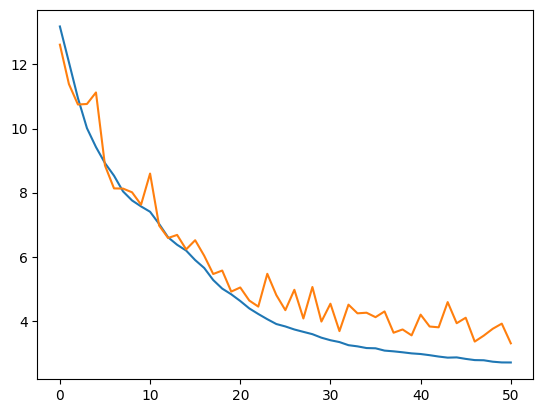

In [27]:
plt.plot(train_losses)
plt.plot(val_losses)

In [28]:
#For bloodmnist
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
contrastive_transforms = ContrastiveTransformations(img_size=64)

data_flag='bloodmnist'

train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl = load_data(img_transforms, contrastive_transforms,data_directory="./",reduction=None, data_flag=data_flag)

bs = 512 # choose an appropriate batch size depending on the computational resources
train_unlabelled_loader = DataLoader(dataset=unlabeled_train_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(dataset=unlabeled_val_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)

simclr = instantiate_SimCLR(device=device,N_batches=len(train_unlabelled_loader),max_epochs=51,bs=bs,data_flag=data_flag)

train_losses, val_losses = simclr.train(train_unlabelled_loader,val_loader, use_amp = True, save=True)

Data loaded
Number of train images: 11959
Number of validation images: 1712
Number of test images: 3421


/tmp/ipykernel_49194/1843024836.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None


Start SimCLR training for 51 epochs.


100%|████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.62it/s]


Epoch: 0, Train Loss: 13.61, Val Loss: 13.48, lr: 0.0030
Saved model checkpoint to ./models/bloodmnist_SimCLR_epoch1.pth


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.51it/s]


Epoch: 1, Train Loss: 13.52, Val Loss: 13.59, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.47it/s]


Epoch: 2, Train Loss: 13.16, Val Loss: 15.51, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Epoch: 3, Train Loss: 13.02, Val Loss: 13.96, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.68it/s]


Epoch: 4, Train Loss: 12.64, Val Loss: 15.14, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Epoch: 5, Train Loss: 12.59, Val Loss: 13.46, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.39it/s]


Epoch: 6, Train Loss: 12.42, Val Loss: 13.43, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.50it/s]


Epoch: 7, Train Loss: 12.34, Val Loss: 13.81, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Epoch: 8, Train Loss: 12.23, Val Loss: 14.11, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Epoch: 9, Train Loss: 12.06, Val Loss: 14.60, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.46it/s]


Epoch: 10, Train Loss: 11.71, Val Loss: 15.13, lr: 0.0030
Saved model checkpoint to ./models/bloodmnist_SimCLR_epoch11.pth


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.55it/s]


Epoch: 11, Train Loss: 11.47, Val Loss: 15.40, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Epoch: 12, Train Loss: 11.66, Val Loss: 13.90, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.57it/s]


Epoch: 13, Train Loss: 11.34, Val Loss: 13.70, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.40it/s]


Epoch: 14, Train Loss: 11.18, Val Loss: 14.30, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.55it/s]


Epoch: 15, Train Loss: 11.04, Val Loss: 15.51, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.72it/s]


Epoch: 16, Train Loss: 10.89, Val Loss: 14.37, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.40it/s]


Epoch: 17, Train Loss: 10.89, Val Loss: 14.44, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.80it/s]


Epoch: 18, Train Loss: 10.76, Val Loss: 14.96, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.69it/s]


Epoch: 19, Train Loss: 10.71, Val Loss: 15.05, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.47it/s]


Epoch: 20, Train Loss: 10.64, Val Loss: 14.12, lr: 0.0030
Saved model checkpoint to ./models/bloodmnist_SimCLR_epoch21.pth


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.72it/s]


Epoch: 21, Train Loss: 10.37, Val Loss: 14.01, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.61it/s]


Epoch: 22, Train Loss: 10.15, Val Loss: 16.05, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Epoch: 23, Train Loss: 9.79, Val Loss: 14.93, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.44it/s]


Epoch: 24, Train Loss: 10.14, Val Loss: 14.57, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.69it/s]


Epoch: 25, Train Loss: 9.71, Val Loss: 17.24, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Epoch: 26, Train Loss: 9.53, Val Loss: 16.64, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Epoch: 27, Train Loss: 9.29, Val Loss: 15.28, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.72it/s]


Epoch: 28, Train Loss: 9.09, Val Loss: 15.59, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Epoch: 29, Train Loss: 9.13, Val Loss: 15.15, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Epoch: 30, Train Loss: 8.90, Val Loss: 15.43, lr: 0.0030
Saved model checkpoint to ./models/bloodmnist_SimCLR_epoch31.pth


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.40it/s]


Epoch: 31, Train Loss: 8.54, Val Loss: 14.13, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.45it/s]


Epoch: 32, Train Loss: 8.38, Val Loss: 13.99, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Epoch: 33, Train Loss: 8.09, Val Loss: 15.95, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.49it/s]


Epoch: 34, Train Loss: 7.85, Val Loss: 15.03, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Epoch: 35, Train Loss: 7.81, Val Loss: 15.63, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.44it/s]


Epoch: 36, Train Loss: 7.69, Val Loss: 15.99, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.57it/s]


Epoch: 37, Train Loss: 7.57, Val Loss: 13.98, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.54it/s]


Epoch: 38, Train Loss: 7.63, Val Loss: 15.79, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.40it/s]


Epoch: 39, Train Loss: 7.37, Val Loss: 16.61, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.48it/s]


Epoch: 40, Train Loss: 7.28, Val Loss: 14.56, lr: 0.0030
Saved model checkpoint to ./models/bloodmnist_SimCLR_epoch41.pth


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Epoch: 41, Train Loss: 7.18, Val Loss: 14.78, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.22it/s]


Epoch: 42, Train Loss: 7.13, Val Loss: 14.09, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.41it/s]


Epoch: 43, Train Loss: 6.99, Val Loss: 15.62, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Epoch: 44, Train Loss: 6.90, Val Loss: 15.12, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.52it/s]


Epoch: 45, Train Loss: 6.96, Val Loss: 15.48, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.38it/s]


Epoch: 46, Train Loss: 6.91, Val Loss: 15.65, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.55it/s]


Epoch: 47, Train Loss: 6.91, Val Loss: 14.17, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa3c5b693a0>
Traceback (most recent call last):
  File "/home/dakbarin/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/dakbarin/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa3c5b693a0>
Traceback (most recent call last):
  File "/home/dakbarin/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: <function _Mult

Epoch: 48, Train Loss: 6.86, Val Loss: 15.80, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.38it/s]


Epoch: 49, Train Loss: 6.71, Val Loss: 15.86, lr: 0.0030


100%|████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.60it/s]


Epoch: 50, Train Loss: 6.65, Val Loss: 16.43, lr: 0.0030
Saved model checkpoint to ./models/bloodmnist_SimCLR_epoch51.pth
Training has finished.


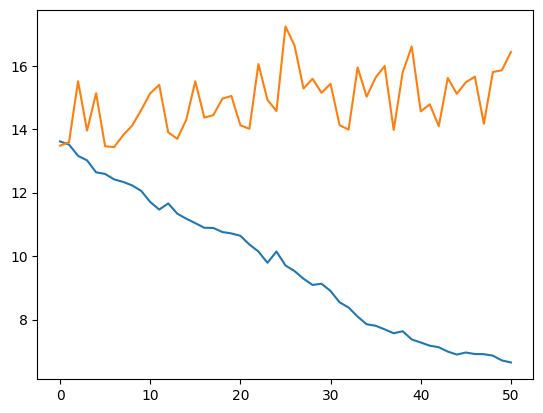

In [29]:
plt.plot(train_losses)
plt.plot(val_losses)

In [32]:
model = instantiate_SimCLR(device=device,N_batches=len(train_unlabelled_loader),max_epochs=101,bs=bs,data_flag=data_flag).model
model = model.to(device)

# 2️⃣ Charger les poids sauvegardés
checkpoint_path = './models/pathmnist_SimCLR_epoch51.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# 3️⃣ (optionnel mais recommandé pour l'inférence)
model.eval()

print("Model loaded and ready for inference!")

Model loaded and ready for inference!


<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 2. Assessing the influence of data-augmentation</h3>

In [118]:
def finetune_l_eval_results_SimCLR(train_dataset, test_dataset, unlabeled_train_dataset_cl,unlabeled_val_dataset_cl, bs, pretrained=True,linear_eval=False,data_flag='pathmnist',g_dim=128,f_dim=None,N_epochs=10,import_model=False,N_epochs_finetuneing=None):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Unsupervised SimCLR training

    train_unlabelled_loader = DataLoader(dataset=unlabeled_train_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)
    val_loader = DataLoader(dataset=unlabeled_val_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)

    N_epochs = N_epochs
    if not N_epochs_finetuneing:
        N_epochs_finetuneing=N_epochs
    if f_dim:
        simclr = instantiate_SimCLR(device=device, N_batches=len(train_unlabelled_loader), max_epochs=N_epochs, bs=bs,data_flag=data_flag,g_dim=g_dim,f_dim=f_dim)
    else:
        simclr = instantiate_SimCLR(device=device, N_batches=len(train_unlabelled_loader), max_epochs=N_epochs, bs=bs,data_flag=data_flag,g_dim=g_dim)
        
    if pretrained:
        simclr.train(train_unlabelled_loader,val_loader, use_amp=True, save=False)
    elif import_model:
        checkpoint_path = f'./models/{data_flag}_SimCLR_epoch{N_epochs}.pth'
        simclr.model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print("Model loaded and ready for inference!")

    # Extract encoder (trained via SimCLR)
    encoder = deepcopy(simclr.model.encoder).to(device)

    if linear_eval:
        for param in encoder.parameters():
            param.requires_grad = False
        label_ratios = [1.0]
    else:
        label_ratios = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0]


    n_classes = len(np.unique(train_dataset.labels))
    
    results = {}

    for ratio in label_ratios:
        if not linear_eval:
            print(f"\nFine-tuning on {int(ratio*100)}% of labeled data")
        else:
            print(f"\nLinear evaluation")

        # --- Select a balanced subset of train_dataset ---
        indices_per_class = {}
        labels = train_dataset.labels.squeeze()

        for c in range(n_classes):
            class_indices = np.where(labels == c)[0]
            n_samples = int(len(class_indices) * ratio)
            selected = np.random.choice(class_indices, n_samples, replace=False)
            indices_per_class[c] = selected

        selected_indices = np.concatenate(list(indices_per_class.values()))
        subset_train_dataset = Subset(train_dataset, selected_indices)

        # --- DataLoader ---
        train_loader = DataLoader(subset_train_dataset, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS)
        test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=NUM_WORKERS)

        # --- Fine-tune classifier ---
        if not f_dim:
            classifier = nn.Linear(512, n_classes).to(device)
        else:
            classifier = nn.Linear(f_dim, n_classes).to(device)
        model = nn.Sequential(encoder, nn.ReLU(), classifier).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        model.train()
        for epoch in tqdm(range(N_epochs_finetuneing)):  
            for inputs, targets in (train_loader):
                inputs, targets = inputs.to(device), targets.squeeze().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        all_preds, all_targets = [], []

        with torch.no_grad():
            for inputs, targets in tqdm(test_loader):
                inputs, targets = inputs.to(device), targets.squeeze().to(device)
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        acc = accuracy_score(all_targets, all_preds)
        print(f"Accuracy for {int(ratio*100)}%: {acc:.4f}")
        results[ratio] = acc

    return results

In [95]:
class TwoViewTransform:
    def __init__(self, transform1, transform2):
        self.transform1 = transform1
        self.transform2 = transform2

    def __call__(self, x):
        return self.transform1(x), self.transform2(x)

In [96]:
# --------- CUTOUT ---------
import torchvision.transforms.functional as TF
class Cutout(object):
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        if not isinstance(img, Image.Image):
            raise TypeError(f"Expected input to be PIL Image, but got {type(img)}")

        img_tensor = TF.to_tensor(img)  # (C, H, W)
        _, h, w = img_tensor.shape

        mask = np.ones((h, w), np.float32)
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.

        mask = torch.from_numpy(mask).expand_as(img_tensor)
        img_tensor = img_tensor * mask

        return TF.to_pil_image(img_tensor)

# --------- SOBEL FILTER ---------
class SobelFilter(object):
    def __call__(self, img):
        img = img.convert('L')  # Convert to grayscale
        img = img.filter(ImageFilter.FIND_EDGES)
        return img.convert('RGB')  # Convert back to RGB for compatibility

# --------- NOISE ---------
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        if not isinstance(img, Image.Image):
            raise TypeError(f"Expected input to be PIL Image, but got {type(img)}")

        tensor_img = TF.to_tensor(img)
        noise = torch.randn_like(tensor_img) * self.std + self.mean
        noisy_img = tensor_img + noise
        noisy_img = torch.clamp(noisy_img, 0., 1.)

        return TF.to_pil_image(noisy_img)

# --------- DEFINE BASE TRANSFORMS ---------
def get_simclr_unit_transforms(img_size):
    transforms_dict = {}

    # 1. CROP
    transforms_dict["Crop"] = transforms.RandomResizedCrop(size=img_size, scale=(0.3, 1.0), ratio=(3/4, 4/3))

    # 2. CUTOUT
    transforms_dict["Cutout"] = Cutout(n_holes=1, length=img_size // 4)

    # 3. COLOR JITTER
    color_jitter = transforms.ColorJitter(0.8, 0.8, 0.4, 0.2)
    transforms_dict["Color"] = transforms.RandomApply([color_jitter], p=1.0)

    # 4. SOBEL
    transforms_dict["Sobel"] = SobelFilter()

    # 5. NOISE
    transforms_dict["Noise"] = AddGaussianNoise(mean=0., std=0.1)

    # 6. BLUR
    transforms_dict["Blur"] = transforms.GaussianBlur(kernel_size=img_size//9, sigma=(0.1, 2.0))

    # 7. ROTATE
    transforms_dict["Rotate"] = transforms.RandomRotation(degrees=30)

    return transforms_dict

In [43]:
unit_transforms = get_simclr_unit_transforms(img_size=64)

# Liste des noms des transformations
transform_names = list(unit_transforms.keys())
n_transforms = len(transform_names)

# Résultats: matrice n x n
results_matrix = np.zeros((n_transforms, n_transforms))

data_flag='pathmnist'

# Boucle principale: tester toutes les paires (t1, t2)
for i, t1_name in enumerate(transform_names[-2:]):
    for j, t2_name in enumerate(transform_names):
        t1_name = "Rotate"
        t2_name = "Rotate"
        print(f"\nTesting {t1_name} + {t2_name}")
        img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        
        # Compose pipeline
        transform_pipeline = TwoViewTransform(
            transforms.Compose([
                unit_transforms[t1_name],
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ]),
            transforms.Compose([
                unit_transforms[t2_name],
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        )

        train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl = load_data(img_transforms, transform_pipeline,data_directory="./",reduction=None, data_flag=data_flag)

        print(len(unlabeled_train_dataset_cl))
        print(len(unlabeled_val_dataset_cl))

        bs = 512 # choose an appropriate batch size depending on the computational resources
        
        # Run linear eval
        acc = finetune_l_eval_results_SimCLR(train_dataset, test_dataset, unlabeled_train_dataset_cl, unlabeled_val_dataset_cl, bs, pretrained=False,linear_eval=True,data_flag=data_flag)[1.0]
        results_matrix[i, j] = acc * 100  
        # Create a DataFrame from the matrix

        df = pd.DataFrame(results_matrix, index=transform_names, columns=transform_names)
        
        # Save to CSV
        csv_path = "transform_combinations_accuracy_matrix.csv"
        df.to_csv(csv_path)
        
        print(f"Saved results matrix to {csv_path}")


Testing Rotate + Rotate


KeyboardInterrupt: 

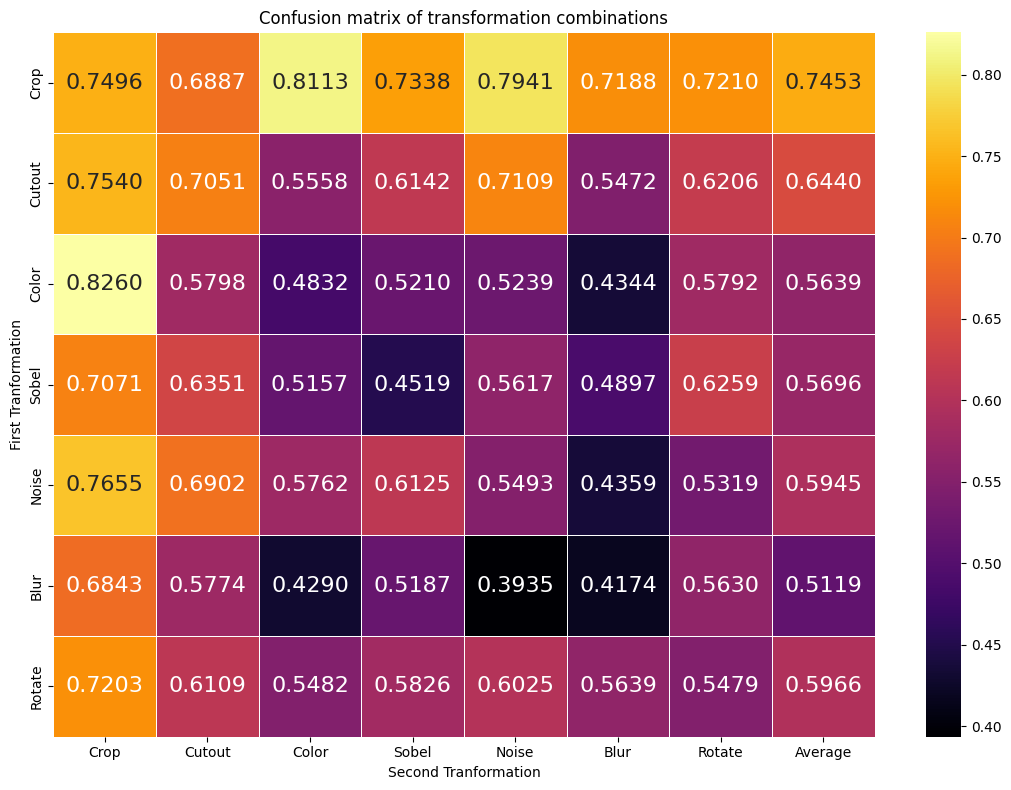

In [109]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Noms des augmentations
augmentations = [
    "Crop", "Cutout", "Color", "Sobel", "Noise", "Blur", "Rotate"
]

# Matrice extraite manuellement depuis l'image
data = np.array([
    [0.7496, 0.6887, 0.8113, 0.7338, 0.7941, 0.7188, 0.7210],
    [0.7540, 0.7051, 0.5558, 0.6142, 0.7109, 0.5472, 0.6206],
    [0.8260, 0.5798, 0.4832, 0.5210, 0.5239, 0.4344, 0.5792],
    [0.7071, 0.6351, 0.5157, 0.4519, 0.5617, 0.4897, 0.6259],
    [0.7655, 0.6902, 0.5762, 0.6125, 0.5493, 0.4359, 0.5319],
    [0.6843, 0.5774, 0.4290, 0.5187, 0.3935, 0.4174, 0.5630],
    [0.7203, 0.6109, 0.5482, 0.5826, 0.6025, 0.5639, 0.5479]
])

# Créer un DataFrame
df = pd.DataFrame(data, index=augmentations, columns=augmentations)

# Ajouter une colonne "Average"
df["Average"] = df.mean(axis=1)

# Affichage de la heatmap
plt.figure(figsize=(11, 8))
sns.heatmap(df, annot=True, fmt=".4f", cmap="inferno", annot_kws={"size": 16}, linewidths=0.5,cbar=True)
plt.title("Confusion matrix of transformation combinations")
plt.xlabel("Second Tranformation")
plt.ylabel("First Tranformation")
plt.tight_layout()
plt.show()

<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 3. Influence of Batch-size</h3>

In [ ]:
batch_sizes = [2**i for i in range(7,12)]

train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl = load_data(img_transforms, ContrastiveTransformations(64),data_directory="./",reduction=None, data_flag=data_flag)

print(len(unlabeled_train_dataset_cl))
print(len(unlabeled_val_dataset_cl))

batch_results = np.zeros(12-7)

for i,bs in enumerate(batch_sizes):
    # Run linear eval
    acc = finetune_l_eval_results_SimCLR(train_dataset, test_dataset, unlabeled_train_dataset_cl, unlabeled_val_dataset_cl, bs, pretrained=False,linear_eval=True,data_flag=data_flag)[1.0]
    batch_results[i] = acc*100
    # Create a DataFrame from the matrix
    
    df = pd.DataFrame({"batch size":batch_sizes,"batch accuracy":batch_results})
    
    # Save to CSV
    csv_path = "batch_size_accuracy_matrix.csv"
    df.to_csv(csv_path,index=False)
    
    print(f"Saved results matrix to {csv_path}")

<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 4. Fine-tuning vs fully supervised</h3>

In [119]:
print("Loading dataset...")
data_flag = 'bloodmnist'
bs = 512
train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl = load_data(img_transforms, ContrastiveTransformations(64),data_directory="./",reduction=None, data_flag=data_flag)

label_ratios = [0.01,0.02, 0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 1.0]

print(len(unlabeled_train_dataset_cl))
print(len(unlabeled_val_dataset_cl))

fully_results = np.zeros(len(label_ratios))

print(f"Running fully supervised")

acc = finetune_l_eval_results_SimCLR(train_dataset, test_dataset, unlabeled_train_dataset_cl, unlabeled_val_dataset_cl, bs, pretrained=False,linear_eval=False,data_flag=data_flag,N_epochs=20)
acc = [(a,b) for (a,b) in acc.items()]
acc = sorted(acc,key=lambda x:x[0])
acc = np.array([x[1] for x in acc])
fully_results = acc*100

print(f"Accuracy:{acc}")

df = pd.DataFrame({"Percentage":label_ratios,"accuracy":fully_results})

# Save to CSV
csv_path = "fully_supervised_accuracy.csv"
df.to_csv(csv_path,index=False)

print(f"Saved results to {csv_path}")

Loading dataset...
Data loaded
Number of train images: 11959
Number of validation images: 1712
Number of test images: 3421
11959
1712
Running fully supervised

Fine-tuning on 1% of labeled data


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.74it/s]


Accuracy for 1%: 0.3595

Fine-tuning on 5% of labeled data


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.74it/s]


Accuracy for 5%: 0.5580

Fine-tuning on 10% of labeled data


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.75it/s]


Accuracy for 10%: 0.8480

Fine-tuning on 20% of labeled data


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.74it/s]


Accuracy for 20%: 0.9433

Fine-tuning on 50% of labeled data


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.31it/s]


Accuracy for 50%: 0.9301

Fine-tuning on 80% of labeled data


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.25it/s]


Accuracy for 80%: 0.9398

Fine-tuning on 100% of labeled data


100%|██████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.26it/s]


Accuracy for 100%: 0.8606
Accuracy:[0.35954399 0.55802397 0.84799766 0.94329144 0.93013739 0.93978369
 0.86056709]


ValueError: All arrays must be of the same length

<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 5. Projection head dimension</h3>

In [23]:
# Liste des noms des transformations
projection_dims = [2**i for i in range(11,13)]

results_vector = np.zeros(len(projection_dims))

data_flag='pathmnist'

# Boucle principale: tester toutes les paires (t1, t2)
for i,f_dim in enumerate(projection_dims):
    print(f"\nTesting f_dim={f_dim}")
    img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl = load_data(img_transforms, ContrastiveTransformations(64),data_directory="./",reduction=None, data_flag=data_flag)

    print(len(unlabeled_train_dataset_cl))
    print(len(unlabeled_val_dataset_cl))

    bs = 512 # choose an appropriate batch size depending on the computational resources
    
    # Run linear eval
    acc = finetune_l_eval_results_SimCLR(train_dataset, test_dataset, unlabeled_train_dataset_cl, unlabeled_val_dataset_cl, bs, pretrained=False,linear_eval=True,data_flag=data_flag,N_epochs=10,f_dim=f_dim)[1.0]
    results_vector[i] = acc * 100  
    # Create a DataFrame from the vector

    df = pd.DataFrame({"f_dim":projection_dims,"accuracy":results_vector})
    
    # Save to CSV
    csv_path = "f_dim_accuracy.csv"
    df.to_csv(csv_path)
    
    print(f"Saved results vector f_dim to {csv_path}")


Testing f_dim=2048


/home/dakbarin/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dakbarin/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_11218/425559983.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None


Data loaded
Number of train images: 89996
Number of validation images: 10004
Number of test images: 7180
89996
10004
Start SimCLR training for 10 epochs.


100%|██████████████████████████████████████████████████████████████| 175/175 [00:21<00:00,  8.24it/s]


Epoch: 0, Train Loss: 13.31, Val Loss: 13.34, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.14it/s]


Epoch: 1, Train Loss: 12.40, Val Loss: 12.89, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:18<00:00,  9.27it/s]


Epoch: 2, Train Loss: 11.59, Val Loss: 11.30, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.02it/s]


Epoch: 3, Train Loss: 10.61, Val Loss: 10.32, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.19it/s]


Epoch: 4, Train Loss: 9.64, Val Loss: 9.50, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:18<00:00,  9.25it/s]


Epoch: 5, Train Loss: 9.07, Val Loss: 8.98, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.18it/s]


Epoch: 6, Train Loss: 8.39, Val Loss: 8.99, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.18it/s]


Epoch: 7, Train Loss: 8.08, Val Loss: 8.21, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.19it/s]


Epoch: 8, Train Loss: 7.76, Val Loss: 9.18, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:18<00:00,  9.30it/s]


Epoch: 9, Train Loss: 7.55, Val Loss: 7.58, lr: 0.0030
Training has finished.

Linear evaluation


100%|████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.00it/s]


Accuracy for 100%: 0.7749
Saved results vector f_dim to f_dim_accuracy.csv

Testing f_dim=4096


/home/dakbarin/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dakbarin/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_11218/425559983.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None


Data loaded
Number of train images: 89996
Number of validation images: 10004
Number of test images: 7180
89996
10004
Start SimCLR training for 10 epochs.


100%|██████████████████████████████████████████████████████████████| 175/175 [00:20<00:00,  8.72it/s]


Epoch: 0, Train Loss: 13.40, Val Loss: 13.71, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.05it/s]


Epoch: 1, Train Loss: 12.66, Val Loss: 14.16, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:18<00:00,  9.27it/s]


Epoch: 2, Train Loss: 12.17, Val Loss: 12.32, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.02it/s]


Epoch: 3, Train Loss: 11.54, Val Loss: 11.27, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.15it/s]


Epoch: 4, Train Loss: 10.79, Val Loss: 10.50, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.11it/s]


Epoch: 5, Train Loss: 10.36, Val Loss: 11.95, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:18<00:00,  9.28it/s]


Epoch: 6, Train Loss: 9.46, Val Loss: 9.01, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:18<00:00,  9.23it/s]


Epoch: 7, Train Loss: 8.68, Val Loss: 8.70, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.03it/s]


Epoch: 8, Train Loss: 8.21, Val Loss: 8.19, lr: 0.0030


100%|██████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.11it/s]


Epoch: 9, Train Loss: 7.91, Val Loss: 8.88, lr: 0.0030
Training has finished.

Linear evaluation


100%|████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.87it/s]


Accuracy for 100%: 0.7741
Saved results vector f_dim to f_dim_accuracy.csv


<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 6. Number of epochs</h3>

In [37]:
# Liste des noms des transformations
epochs_list = [10*i+1 for i in range(4,6)]

results_vector = np.zeros(len(epochs_list))

data_flag='pathmnist'

# Boucle principale: tester toutes les paires (t1, t2)
for i,n_epochs in enumerate(epochs_list):
    print(f"\nTesting n_epochs={n_epochs}")
    if i==0:
        n_epochs_finetune = 10
    else:
        n_epochs_finetune=n_epochs
    img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl = load_data(img_transforms, ContrastiveTransformations(64),data_directory="./",reduction=None, data_flag=data_flag)

    print(len(unlabeled_train_dataset_cl))
    print(len(unlabeled_val_dataset_cl))

    bs = 512 # choose an appropriate batch size depending on the computational resources
    
    # Run linear eval
    acc = finetune_l_eval_results_SimCLR(train_dataset, test_dataset, unlabeled_train_dataset_cl, unlabeled_val_dataset_cl, bs, pretrained=False,linear_eval=True,data_flag=data_flag,N_epochs=n_epochs,import_model=True,N_epochs_finetuneing=n_epochs_finetune)[1.0]
    results_vector[i] = acc * 100  
    # Create a DataFrame from the vector

    df = pd.DataFrame({"n_epochs":epochs_list,"accuracy":results_vector})
    
    # Save to CSV
    csv_path = "n_epochs_accuracy.csv"
    df.to_csv(csv_path)
    
    print(f"Saved results vector n_epochs to {csv_path}")


Testing n_epochs=41
Data loaded
Number of train images: 89996
Number of validation images: 10004
Number of test images: 7180
89996
10004
Model loaded and ready for inference!

Linear evaluation


100%|████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.16it/s]


Accuracy for 100%: 0.8447
Saved results vector n_epochs to n_epochs_accuracy.csv

Testing n_epochs=51
Data loaded
Number of train images: 89996
Number of validation images: 10004
Number of test images: 7180
89996
10004


/home/dakbarin/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dakbarin/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded and ready for inference!

Linear evaluation


100%|████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.14it/s]

Accuracy for 100%: 0.8487
Saved results vector n_epochs to n_epochs_accuracy.csv


<h2 style="background-color:gray;color:white;padding:20px;border-radius:8px">Second SSL technique: Barlowtwins</h2>

In [97]:
class BarlowTwins:
    def __init__(self, model, optimizer, scheduler, device, batch_size, lambd, epochs, data_flag):
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.lambd = lambd
        self.epochs = epochs
        self.data_flag = data_flag

    def barlow_twins_loss(self, z1, z2):
        N, D = z1.size()
        # Normalize embeddings
        z1_norm = (z1 - z1.mean(0)) / z1.std(0)
        z2_norm = (z2 - z2.mean(0)) / z2.std(0)

        c = torch.mm(z1_norm.T, z2_norm) / N  # cross-correlation matrix

        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = (c.flatten()[1:].view(D - 1, D + 1)[:, :-1].pow_(2).sum())

        loss = on_diag + self.lambd * off_diag
        return loss

    def train(self, train_loader, val_loader, save=True, use_amp=False):
        scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None

        print(f"Start Barlow Twins training for {self.epochs} epochs.")
        train_losses, val_losses = [], []

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0

            for (x1, x2), _ in tqdm(train_loader):  # Expecting train_loader to yield pairs of augmented images
                x1, x2 = x1.to(self.device), x2.to(self.device)

                if torch.cuda.is_available() and use_amp:
                    with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
                        z1 = self.model(x1)
                        z2 = self.model(x2)
                        loss = self.barlow_twins_loss(z1, z2)
                else:
                    z1 = self.model(x1)
                    z2 = self.model(x2)
                    loss = self.barlow_twins_loss(z1, z2)

                self.optimizer.zero_grad()
                if scaler is not None:
                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    self.optimizer.step()

                running_loss += loss.item() * x1.size(0)

            avg_train_loss = running_loss / len(train_loader.dataset)

            if epoch >= 5:
                self.scheduler.step()

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for (vx1, vx2), _ in val_loader:
                    vx1, vx2 = vx1.to(self.device), vx2.to(self.device)
                    z1 = self.model(vx1)
                    z2 = self.model(vx2)
                    loss = self.barlow_twins_loss(z1, z2)
                    val_loss += loss.item() * vx1.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            print(f"Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {self.scheduler.get_last_lr()[0]:.6f}")

            if (epoch) % 10 == 0 and save:
                os.makedirs("./models", exist_ok=True)
                save_path = f"./models/{self.data_flag}_BarlowTwins_epoch{epoch+1}.pth"
                torch.save(self.model.state_dict(), save_path)
                print(f"Saved model checkpoint to {save_path}")

        print("Training has finished.")
        return train_losses, val_losses


In [98]:
class BTModel(nn.Module):
    def __init__(self,encoder,projector):
        super(BTModel, self).__init__()
        self.encoder=encoder
        self.projector=projector
    
    def forward(self,x):
        x = self.encoder(x)
        x = self.projector(x)
        return x

In [99]:
def instantiate_BT(max_epochs=50,lr=0.003,wd=1e-4,f_dim=512,lambd=1e-2,g_dim=128,device='cpu',N_batches=None,bs=None,data_flag='pathmnist'):
    # Encoder f
    f = models.resnet18(pretrained=False) #  Wf()
    if f_dim != 512:
        f.fc = nn.Linear(512,f_dim).to(device)
        g = nn.Sequential(
        nn.ReLU(),
        nn.Linear(f_dim, g_dim)
    ).to(device)
    else:
        f.fc = nn.Identity().to(device)  # we remove the classification layer to get raw features
        # f.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) #Adapting Resnet to smaller images
        # f.maxpool = nn.Identity()
        # Projection head g()
        g = nn.Sequential(
            nn.Linear(f_dim, f_dim),
            nn.ReLU(),
            nn.Linear(f_dim, g_dim)
        ).to(device)
    
    model = BTModel(f,g)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs * N_batches, last_epoch=-1)
    barlow_twins = BarlowTwins(model=model, optimizer=optimizer,scheduler=scheduler, device=device, batch_size=bs,lambd=lambd, epochs=max_epochs,data_flag=data_flag)
    return barlow_twins

In [ ]:
#For pathmnist
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
contrastive_transforms = ContrastiveTransformations(img_size=64)

data_flag='pathmnist'

train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl = load_data(img_transforms, contrastive_transforms,data_directory="./",reduction=None, data_flag=data_flag)

bs = 512 # choose an appropriate batch size depending on the computational resources
train_unlabelled_loader = DataLoader(dataset=unlabeled_train_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(dataset=unlabeled_val_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)

barlow_twins = instantiate_BT(device=device,N_batches=len(train_unlabelled_loader),max_epochs=1,bs=bs,data_flag=data_flag)

train_losses, val_losses = barlow_twins.train(train_unlabelled_loader,val_loader, use_amp = True, save=True)

<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 2. Assessing the influence of data-augmentation</h3>

In [104]:
def finetune_l_eval_results_Barlow_Twins(train_dataset, test_dataset, unlabeled_train_dataset_cl,unlabeled_val_dataset_cl, bs, pretrained=True,linear_eval=False,data_flag='pathmnist',g_dim=128,f_dim=None,N_epochs=10,import_model=False,N_epochs_finetuneing=None):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Unsupervised SimCLR training

    train_unlabelled_loader = DataLoader(dataset=unlabeled_train_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)
    val_loader = DataLoader(dataset=unlabeled_val_dataset_cl, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)

    N_epochs = N_epochs
    if f_dim:
        barlow_twins = instantiate_BT(device=device, N_batches=len(train_unlabelled_loader), max_epochs=N_epochs, bs=bs,data_flag=data_flag,g_dim=g_dim,f_dim=f_dim)
    else:
        barlow_twins = instantiate_BT(device=device, N_batches=len(train_unlabelled_loader), max_epochs=N_epochs, bs=bs,data_flag=data_flag,g_dim=g_dim)
        
    if pretrained:
        barlow_twins.train(train_unlabelled_loader,val_loader, use_amp=True, save=False)
    elif import_model:
        checkpoint_path = f'./models/{data_flag}_BarlowTwins_epoch{N_epochs}.pth'
        barlow_twins.model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print("Model loaded and ready for inference!")        

    # Extract encoder (trained via SimCLR)
    encoder = deepcopy(barlow_twins.model.encoder).to(device)

    if linear_eval:
        for param in encoder.parameters():
            param.requires_grad = False
        label_ratios = [1.0]
    else:
        label_ratios = [0.01,0.02, 0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 1.0]
        label_ratios = [0.7]


    n_classes = len(np.unique(train_dataset.labels))
    
    results = {}

    for ratio in label_ratios:
        if not linear_eval:
            print(f"\nFine-tuning on {int(ratio*100)}% of labeled data")
        else:
            print(f"\nLinear evaluation")

        # --- Select a balanced subset of train_dataset ---
        indices_per_class = {}
        labels = train_dataset.labels.squeeze()

        for c in range(n_classes):
            class_indices = np.where(labels == c)[0]
            n_samples = int(len(class_indices) * ratio)
            selected = np.random.choice(class_indices, n_samples, replace=False)
            indices_per_class[c] = selected

        selected_indices = np.concatenate(list(indices_per_class.values()))
        subset_train_dataset = Subset(train_dataset, selected_indices)

        # --- DataLoader ---
        train_loader = DataLoader(subset_train_dataset, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS)
        test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=NUM_WORKERS)

        # --- Fine-tune classifier ---
        if not f_dim:
            classifier = nn.Linear(512, n_classes).to(device)
        else:
            classifier = nn.Linear(f_dim, n_classes).to(device)
        model = nn.Sequential(encoder, nn.ReLU(), classifier).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        model.train()
        for epoch in tqdm(range(N_epochs)):  
            for inputs, targets in (train_loader):
                inputs, targets = inputs.to(device), targets.squeeze().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        all_preds, all_targets = [], []

        with torch.no_grad():
            for inputs, targets in tqdm(test_loader):
                inputs, targets = inputs.to(device), targets.squeeze().to(device)
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        acc = accuracy_score(all_targets, all_preds)
        print(f"Accuracy for {int(ratio*100)}%: {acc:.4f}")
        results[ratio] = acc

    return results

<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 3. Influence of Batch-size</h3>

In [ ]:
batch_sizes = [2**i for i in range(4,7)]

train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl = load_data(img_transforms, ContrastiveTransformations(64),data_directory="./",reduction=None, data_flag=data_flag)

print(len(unlabeled_train_dataset_cl))
print(len(unlabeled_val_dataset_cl))

batch_results = np.zeros(len(batch_sizes))

for i,bs in enumerate(batch_sizes):
    print(f"Batch_size={bs}")
    # Run linear eval
    acc = finetune_l_eval_results_Barlow_Twins(train_dataset, test_dataset, unlabeled_train_dataset_cl, unlabeled_val_dataset_cl, bs, pretrained=True,linear_eval=True,data_flag=data_flag,N_epochs=11)[1.0]
    batch_results[i] = acc*100
    # Create a DataFrame from the matrix
    print(f"Accuracy:{acc}")
    
    df = pd.DataFrame({"batch size":batch_sizes,"batch accuracy":batch_results})
    
    # Save to CSV
    csv_path = "batch_size_accuracy_matrix.csv"
    df.to_csv(csv_path,index=False)
    
    print(f"Saved results matrix to {csv_path}")

<h3 style="background-color:#1f77b4;color:white;padding:8px;border-radius:6px"> 4. Fine-tuning vs fully supervised</h3>

In [110]:
print("Loading dataset...")
data_flag = 'pathmnist'
bs = 512
train_dataset,val_dataset,test_dataset,unlabeled_train_dataset_cl,unlabeled_val_dataset_cl = load_data(img_transforms, ContrastiveTransformations(64),data_directory="./",reduction=None, data_flag=data_flag)

label_ratios = [0.01,0.02, 0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 1.0]

print(len(unlabeled_train_dataset_cl))
print(len(unlabeled_val_dataset_cl))

fully_results = np.zeros(len(label_ratios))

print(f"Running fully supervised")

acc = finetune_l_eval_results_Barlow_Twins(train_dataset, test_dataset, unlabeled_train_dataset_cl, unlabeled_val_dataset_cl, bs, pretrained=True,linear_eval=False,data_flag=data_flag,N_epochs=20)
acc = [(a,b) for (a,b) in acc.items()]
acc = sorted(acc,key=lambda x:x[0])
acc = np.array([x[1] for x in acc])
fully_results = acc*100

print(f"Accuracy:{acc}")

df = pd.DataFrame({"Percentage":label_ratios,"accuracy":fully_results})

# Save to CSV
csv_path = "fully_supervised_accuracy.csv"
df.to_csv(csv_path,index=False)

print(f"Saved results to {csv_path}")

Loading dataset...


/home/dakbarin/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dakbarin/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_59877/1258417319.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None


Data loaded
Number of train images: 89996
Number of validation images: 10004
Number of test images: 7180
89996
10004
Running fully supervised
Start Barlow Twins training for 20 epochs.


100%|██████████████████████████████████████████████████████████████| 175/175 [00:15<00:00, 11.35it/s]


Epoch: 0, Train Loss: 61.4369, Val Loss: 53.4271, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: 1, Train Loss: 42.1842, Val Loss: 40.0201, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.16it/s]


Epoch: 2, Train Loss: 36.9903, Val Loss: 37.6072, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.07it/s]


Epoch: 3, Train Loss: 31.4972, Val Loss: 31.6485, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: 4, Train Loss: 27.6121, Val Loss: 27.7847, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.03it/s]


Epoch: 5, Train Loss: 23.2097, Val Loss: 25.5596, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.27it/s]


Epoch: 6, Train Loss: 20.5868, Val Loss: 21.9441, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 11.92it/s]


Epoch: 7, Train Loss: 18.7555, Val Loss: 18.1287, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: 8, Train Loss: 17.1185, Val Loss: 19.1992, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.21it/s]


Epoch: 9, Train Loss: 15.3550, Val Loss: 18.0785, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.10it/s]


Epoch: 10, Train Loss: 13.9876, Val Loss: 13.4026, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 11.99it/s]


Epoch: 11, Train Loss: 12.9859, Val Loss: 13.3791, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: 12, Train Loss: 12.0056, Val Loss: 19.8167, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.14it/s]


Epoch: 13, Train Loss: 11.4527, Val Loss: 15.8725, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 11.96it/s]


Epoch: 14, Train Loss: 10.9521, Val Loss: 13.2444, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: 15, Train Loss: 10.5782, Val Loss: 12.2951, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 11.97it/s]


Epoch: 16, Train Loss: 10.2677, Val Loss: 10.3036, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.04it/s]


Epoch: 17, Train Loss: 9.7871, Val Loss: 12.1213, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.11it/s]


Epoch: 18, Train Loss: 9.5169, Val Loss: 10.8425, LR: 0.003000


100%|██████████████████████████████████████████████████████████████| 175/175 [00:14<00:00, 12.07it/s]


Epoch: 19, Train Loss: 9.2134, Val Loss: 9.7159, LR: 0.003000
Training has finished.

Fine-tuning on 70% of labeled data


100%|████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.54it/s]


Accuracy for 70%: 0.8508
Accuracy:[0.85083565]


ValueError: All arrays must be of the same length